# XGBoost для бинарной классификации снимков

In [ ]:
# Импорт библиотек
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from PIL import Image
from imblearn.over_sampling import SMOTE
import os

# Загрузка изображений и меток 
def load_images_and_labels(root_dir):
    images = []
    labels = []
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            label = 0 if class_dir == "class0" else 1
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
                labels.append(label)
    return images, np.array(labels)

# Извлечение признаков 
def extract_features(images, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    model.to(device)

    features_list = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch = torch.stack(batch).to(device)
            feats = model(batch)
            feats = feats.view(feats.size(0), -1)
            features_list.append(feats.cpu().numpy())
    return np.vstack(features_list)


In [ ]:
# Подготовка данных
root_dir = r"D:\URFU\VKR\Ind_pract\dissert\data\classification"
images, labels = load_images_and_labels(root_dir)
features = extract_features(images)

In [ ]:
# Разделение данных на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# Устранение дисбаланса классов
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train) # type: ignore


## Обучение модели

In [ ]:
# Обучение модели XGBoost
from sklearn.model_selection import GridSearchCV

# Задаём сетку гиперпараметров
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'reg_alpha': [0.1, 0.5]
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist', 
    device='cuda'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_log_loss',
    verbose=2,
    n_jobs=1
)

# Поиск лучших гиперпараметров
grid_search.fit(X_train, y_train) # type: ignore

# Лучшая модель и параметры
best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.5, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.5, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7

## Оценка модели

In [ ]:
# Оценка модели
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


Accuracy: 0.7250
F1 Score: 0.7188
ROC-AUC: 0.8074


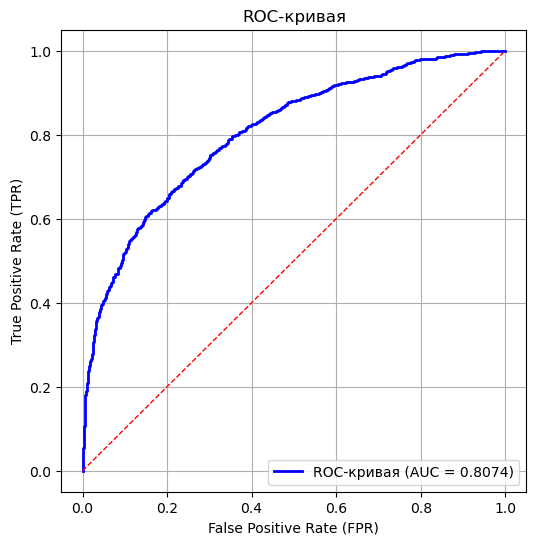

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Строим ROC-кривую для бинарной классификации
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# График
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC-кривая (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Cохранение модели 

In [ ]:
import joblib
# Сохраняем модель
joblib.dump(best_model, r'D:\URFU\VKR\Ind_pract\dissert\data\checkpoints\best_xgb_model.joblib')

## Инференс

In [7]:
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
import joblib
from torchvision import transforms
import time

# Функция для загрузки и предобработки изображения
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)   # type: ignore

# Функция для извлечения признаков
def extract_features_for_inference(image_tensor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Загружаем ResNet50 без головы
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        features = model(image_tensor.to(device))
        return features.view(features.size(0), -1).cpu().numpy()

# Загрузка обученной модели
model_path = r'D:\URFU\VKR\Ind_pract\dissert\data\checkpoints\best_xgb_model.joblib'
loaded_model = joblib.load(model_path)

# Функция инференса с измерением времени
def predict_image(image_path):
    start_time = time.time() 
    
    # Предобработка изображения
    preprocessed_img = preprocess_image(image_path)
    
    # Извлечение признаков
    features = extract_features_for_inference(preprocessed_img)
    
    # Предсказание
    proba = loaded_model.predict_proba(features)[0][1]
    prediction = loaded_model.predict(features)[0]
    
    end_time = time.time() 
    inference_time = end_time - start_time
    
    return {
        'class': int(prediction),
        'probability': round(proba, 4),
        'time': round(inference_time, 4)
    }

# Пример использования
test_image_path = r"D:\URFU\VKR\Ind_pract\dissert\data\segmentation\train\images\83-5-076-494_037_017.png"

result = predict_image(test_image_path)
print(f"Предсказание: Класс {result['class']}")
print(f"Вероятность: {result['probability']}" )
print(f"Время инференса: {result['time']} секунд")

Предсказание: Класс 0
Вероятность: 0.367000013589859
Время инференса: 0.6644 секунд
